In [95]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
import cv2
from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

In [96]:
df = pd.read_csv("train_set.csv")

In [97]:
df["label"].value_counts()

label
happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
disgust      436
Name: count, dtype: int64

In [98]:
ROOT_PATH = os.getcwd()

TRAIN_PATH = ROOT_PATH + "\\data\\data\\images\\train"
TEST_PATH = ROOT_PATH + "\\data\\data\\images\\test"
filenames_train = os.listdir(TRAIN_PATH)
filenames_test = os.listdir(TEST_PATH)

IMAGE_WIDTH=48
IMAGE_HEIGHT=48
IMAGE_CHANNELS=1
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
EPOCHS = 12
earlystop = EarlyStopping(patience=5)
mcheckpoint = ModelCheckpoint("ej_paisaje.h5")
label_encoder = LabelEncoder()

In [99]:
print(ROOT_PATH)
print(TRAIN_PATH)
print(filenames_train)

c:\Users\adria\Desktop\emociones
c:\Users\adria\Desktop\emociones\data\data\images\train
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [100]:
def read_data(path, archivos, im_size):
    X = []
    Y = []

    ##### CODE #####
    # Iterar sobre todo lo que haya en path
    for i in archivos:
        current_path = os.path.join(path, i)

        for j in os.listdir(current_path):
            image_path = os.path.join(current_path, j)
            #print(image_path)
            # Leer la imagen y aplicarle el resize
            image = imread(image_path, 0)
            smallimage = cv2.resize(image, (im_size, im_size))
            # Guardo en X
            X.append(smallimage)
            Y.append(i)
            

        
    
    return np.array(X),Y

X, y = read_data(TRAIN_PATH, filenames_train, IMAGE_WIDTH)
testeox, testeoy = read_data(TRAIN_PATH, filenames_test, IMAGE_WIDTH)

print(X.shape)

(28821, 48, 48)


In [101]:
test = pd.read_csv("test_set.csv")
test

,id_img
0,10052
1,10065
2,10079
3,10095
4,10121
...,...
7061,9806
7062,9830
7063,9853
7064,9878


(48, 48)


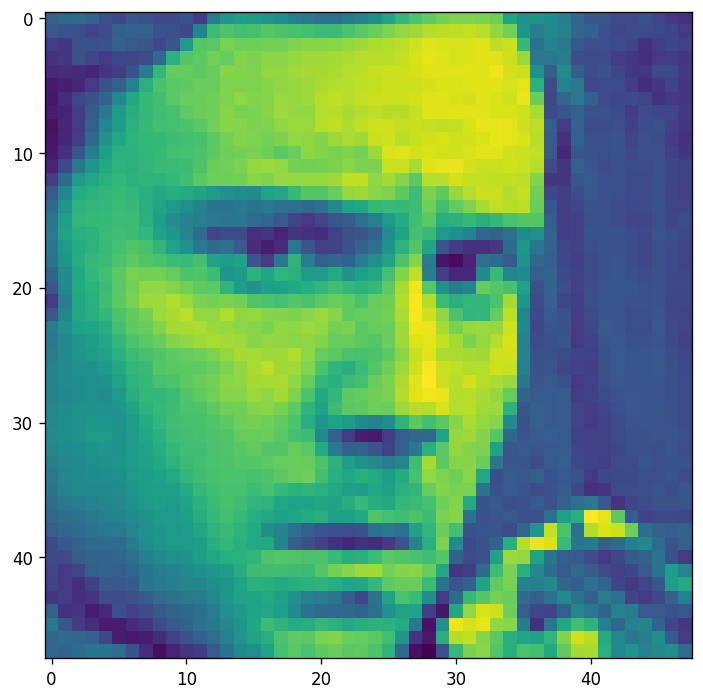

In [102]:
print(X[0].shape)
plt.imshow(X[0]);

In [103]:
y = label_encoder.fit_transform(y)
y = np.array(y)
print(y.max())

6


In [104]:
"""y_test = label_encoder.fit_transform(y)
y_test = np.array(y_test)"""

'y_test = label_encoder.fit_transform(y)\ny_test = np.array(y_test)'

In [105]:
print("Min:", np.min(X))
print("Max:", np.max(X))

Min: 0
Max: 255


In [106]:
X = X / 255.0
testeox = testeox / 255

In [107]:
print("Min:", np.min(X))
print("Max:", np.max(X))

Min: 0.0
Max: 1.0


In [117]:
print(X.shape)
print(y.shape)

(28821, 48, 48, 1)
(28821,)


In [118]:
X = np.expand_dims(X, -1) #redimensiona el array para poder usarlo en el modelo
"""X_test = np.expand_dims(X_test, -1)"""

'X_test = np.expand_dims(X_test, -1)'

In [119]:
print(X.shape)
print(y.shape)

(28821, 48, 48, 1, 1)
(28821,)


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=.2)

In [112]:
layers = [
    keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=IMAGE_SIZE), #como tiene el input_shape es la de entrada
    keras.layers.MaxPooling2D(pool_size=(2,2)),


    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(7, activation='softmax') #sigmoid es para binario, para multiclase
]


model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [113]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 23, 23, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 23, 23, 128)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 21, 21, 64)        73792     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 10, 10, 64)       

In [114]:
print(X_train.shape)
print(y_train.shape)

(23056, 48, 48, 1)
(23056,)


In [115]:
history = model.fit(X_train,
         y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [earlystop, mcheckpoint],
         validation_split = 0.2)

Epoch 1/50
577/577 [==============================] - 57s 98ms/step - loss: 1.7884 - accuracy: 0.2639 - val_loss: 1.6492 - val_accuracy: 0.3634
Epoch 2/50
  1/577 [..............................] - ETA: 53s - loss: 1.6242 - accuracy: 0.5000

c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


577/577 [==============================] - 57s 98ms/step - loss: 1.5813 - accuracy: 0.3841 - val_loss: 1.4831 - val_accuracy: 0.4265
Epoch 3/50
577/577 [==============================] - 53s 92ms/step - loss: 1.4576 - accuracy: 0.4393 - val_loss: 1.4028 - val_accuracy: 0.4675
Epoch 4/50
577/577 [==============================] - 57s 98ms/step - loss: 1.3749 - accuracy: 0.4723 - val_loss: 1.3238 - val_accuracy: 0.4892
Epoch 5/50
577/577 [==============================] - 57s 99ms/step - loss: 1.3088 - accuracy: 0.4991 - val_loss: 1.2866 - val_accuracy: 0.5082
Epoch 6/50
577/577 [==============================] - 59s 103ms/step - loss: 1.2644 - accuracy: 0.5121 - val_loss: 1.2617 - val_accuracy: 0.5145
Epoch 7/50
577/577 [==============================] - 53s 92ms/step - loss: 1.2178 - accuracy: 0.5361 - val_loss: 1.2432 - val_accuracy: 0.5284
Epoch 8/50
577/577 [==============================] - 53s 92ms/step - loss: 1.1741 - accuracy: 0.5513 - val_loss: 1.2342 - val_accuracy: 0.5267
Ep

KeyboardInterrupt: 

In [121]:
results = model.evaluate(X_test, y_test)
results

InvalidArgumentError: Graph execution error:

Detected at node sequential_6/conv2d_14/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1046, in launch_instance

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\adria\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\adria\AppData\Local\Temp\ipykernel_9656\2067961499.py", line 1, in <module>

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2296, in evaluate

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 4108, in run_step

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2066, in test_function

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2049, in step_function

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2037, in run_step

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1917, in test_step

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 321, in call

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\activations.py", line 306, in relu

  File "c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5395, in relu

Computed output size would be negative: -1 [input_size: 1, effective_filter_size: 3, stride: 1]
	 [[{{node sequential_6/conv2d_14/Relu}}]] [Op:__inference_test_function_96270]

In [ ]:
predicciones = model.predict(testeox)

221/221 [==============================] - 3s 11ms/step


In [ ]:
labels = np.argmax(predicciones, axis=1)

In [ ]:
lista = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad','surprise']
dicc = {nombre:i for i, nombre in enumerate(lista)}
lista_labels = [lista[i] for i in labels]

In [ ]:
submission = pd.DataFrame()
submission['id_img'] = test['id_img']
submission['label'] = lista_labels
submission.head()

,id_img,label
0,10052,angry
1,10065,happy
2,10079,sad
3,10095,fear
4,10121,neutral


In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
layers2 = [
    keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=IMAGE_SIZE), #como tiene el input_shape es la de entrada
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.1),
    
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(7, activation='softmax') #sigmoid es para binario, para multiclase
]


model2 = keras.Sequential(layers2)

model2.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [ ]:
history2 = model2.fit(X_train,
         y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [earlystop, mcheckpoint],
         validation_split = 0.2)

Epoch 1/50
73/73 [==============================] - 44s 596ms/step - loss: 1.8310 - accuracy: 0.2463 - val_loss: 1.8125 - val_accuracy: 0.2411
Epoch 2/50


c:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


73/73 [==============================] - 44s 597ms/step - loss: 1.8160 - accuracy: 0.2464 - val_loss: 1.8075 - val_accuracy: 0.2411
Epoch 3/50
73/73 [==============================] - 44s 599ms/step - loss: 1.8170 - accuracy: 0.2464 - val_loss: 1.8083 - val_accuracy: 0.2411
Epoch 4/50
24/73 [========>.....................] - ETA: 28s - loss: 1.8168 - accuracy: 0.2448

KeyboardInterrupt: 